###  Imports

In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

### Get data from Reddit

In [2]:
depressedData = pd.read_csv('./../Data/depressed_posts.csv')
unpopularopinionData = pd.read_csv('./../Data/unpopularopinion_posts.csv')
lonelyData = pd.read_csv('./../Data/lonely_posts.csv')
machinelearningData = pd.read_csv('./../Data/machinelearning_posts.csv')

### Clean r/lonely data

In [3]:
print(len(lonelyData))

980


In [4]:
lonelyData = lonelyData[lonelyData['Post'].notna()]
print(len(lonelyData))

980


In [5]:
lonelyData['Post'] = lonelyData['Post'].astype(str)
print(len(lonelyData))

980


In [6]:
allPosts = lonelyData

posessivePronouns = "'s"
apostrophe="’"
someSigns ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = ' \d+(\.\d+)? '
punctuation = "[^\w\s]" 
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

allPosts['Post_Parsed'] = allPosts['Post'].str.lower()
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(posessivePronouns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(apostrophe,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(someSigns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(urls,' url ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(numbers,' nmbr ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(punctuation,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(whitespaces,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(leadTrailWhitespace,' ',regex=True)

In [7]:
allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed
0,imborderlinebaby,lonely,1.620396e+09,18M - let’s play word hunt,"literally the title. this sounds pathetic, but...",literally the title this sounds pathetic but i...
1,Sad_Mission6381,lonely,1.620103e+09,Looking for some International friends!!,"Hi,\n\nI'm from India. I always wanted to know...",hi i m from india i always wanted to know more...
2,darling-driver,lonely,1.619963e+09,To deserve being loved,I'll probably not be able to make myself clear...,i ll probably not be able to make myself clear...
3,Elavanor,lonely,1.620513e+09,I met happiness,"(For first, my gramatics, is really bad so ple...",for first my gramatics is really bad so pleas...
4,Intelligent_Seat_116,lonely,1.620083e+09,25 M looking for real friends.,"Hello everyone, i am a talkative guy.\nI need ...",hello everyone i am a talkative guy i need rea...


In [8]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
nrows = len(allPosts)
lemmatized_text_list = []

for post in allPosts.Post_Parsed:
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = post
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [11]:
allPosts['Post_Parsed'] = lemmatized_text_list

In [12]:
allPosts.loc[1]['Post_Parsed']

'hi i m from india i always want to know more about other country culture unfortunately i haven t be able to visit any other country if anyone be free kind enough to talk please dm i wish to know more about your country the culture there and much more thank you in advance '

In [13]:
# stop words
with open('./../stopwords_no_punct.data', 'rb') as filehandle:
    # read the data as binary data stream
    stop_words_no_punct = pickle.load(filehandle)

In [14]:
from nltk.tokenize import word_tokenize
post_without_stop_words = []

for post in allPosts.Post_Parsed:
    text_tokens = word_tokenize(post)
    tokens_without_stop_words = [word for word in text_tokens if not word in stop_words_no_punct]
    post_without_stop_words.append((" ").join(tokens_without_stop_words))

allPosts['Post_Parsed'] = post_without_stop_words

In [15]:
allPosts.loc[1]['Post_Parsed']

'hi india always want know country culture unfortunately able visit country anyone free kind enough talk please dm wish know country culture much thank advance'

In [16]:
lonelyData = allPosts

lonelyData.to_csv('lonely_posts_processed.csv', index=False)

### Generating Features

In [17]:
from nltk.tokenize import word_tokenize

def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post_Parsed:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [18]:
freqWordsLonely = getWordFrequency('lonely_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsLonely)))
print('Most common words: {}'.format(freqWordsLonely.most_common(100)))

word_features_lonely = list(freqWordsLonely.keys())[:1500]

Number of words: 6520
Most common words: [('feel', 1128), ('like', 1085), ('get', 902), ('want', 791), ('people', 754), ('friends', 745), ('go', 707), ('im', 668), ('know', 648), ('make', 623), ('talk', 602), ('time', 578), ('one', 564), ('life', 541), ('even', 534), ('nmbr', 495), ('think', 474), ('really', 443), ('someone', 434), ('try', 431), ('never', 421), ('would', 399), ('love', 351), ('say', 349), ('lonely', 337), ('alone', 337), ('always', 287), ('tell', 286), ('much', 284), ('day', 278), ('person', 275), ('friend', 258), ('anyone', 255), ('see', 254), ('find', 253), ('live', 247), ('things', 244), ('years', 238), ('need', 230), ('way', 230), ('something', 228), ('still', 227), ('start', 224), ('work', 224), ('leave', 216), ('back', 209), ('ive', 207), ('end', 203), ('school', 203), ('keep', 198), ('come', 196), ('good', 196), ('could', 195), ('long', 191), ('take', 191), ('look', 191), ('care', 186), ('help', 186), ('every', 184), ('anything', 182), ('also', 182), ('social', 

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


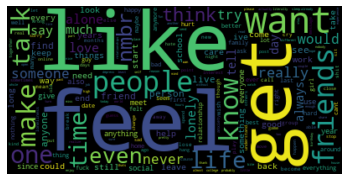

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = freqWordsLonely
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

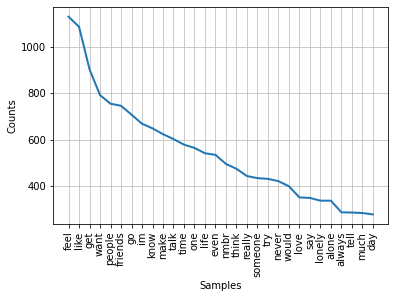

In [20]:
import matplotlib.pyplot as plt
freqWordsLonely.plot(30,cumulative=False)
plt.show()